<a href="https://colab.research.google.com/github/deepakri201/SEG_and_SR_for_NLSTSeg/blob/main/compare_to_ts/NLSTSeg_compare_SEG_to_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare the lesion segmentations from NLSTSeg to what was produced by TotalSegmentator


Deepa Krishnaswamy

Brigham and Women's Hospital

September 2025

# Parameterization

In [1]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup

In [2]:
!pip install idc-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 82.6 MB/s eta 0:00:00
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.3.2
    Uninstalling duckdb-1.3.2:
      Successfully uninstalled duckdb-1.3.2


In [3]:
import os
import sys
import time

import numpy as np
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

import json
from pathlib import Path

In [4]:
import matplotlib.patches as patches

In [5]:
from google.cloud import bigquery
from google.cloud import storage

In [6]:
import datetime

In [7]:
from idc_index import IDCClient

idc_client = IDCClient.client()

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
!pip install pydicom
import pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.4 MB/s eta 0:00:00


# Find a series that has both the NLSTSeg DICOM SEG and the TotalSegmentator segmentation

In [10]:
client_bq = bigquery.Client(project=project_name)

In [11]:
# Get the Referenced SeriesInstanceUIDs of the NLSTSeg

query = f"""
  SELECT
    DISTINCT(segmented_SeriesInstanceUID)
  FROM
    `idc-external-018.nlstseg_seg_and_sr.segmentations_100`
"""
df_nlstseg = client_bq.query(query).to_dataframe()

In [12]:
# Get the Referenced SeriesInstanceUIDs of TotalSegmentator

query = f"""
  SELECT DISTINCT
  PatientID,
  StudyInstanceUID,
  segmented_SeriesInstanceUID
FROM
  `bigquery-public-data.idc_current.segmentations`
WHERE EXISTS (
  SELECT 1
  FROM UNNEST(SegmentAlgorithmName) AS name
  WHERE name LIKE '%TotalSegmentator v1.5.6%' AND
  (SegmentedPropertyType.CodeMeaning = 'Lower lobe of lung' OR
   SegmentedPropertyType.CodeMeaning = 'Upper lobe of lung' OR
   SegmentedPropertyType.CodeMeaning = 'Middle lobe of right lung')
)
ORDER BY
  PatientID,
  StudyInstanceUID,
  segmented_SeriesInstanceUID
"""
df_ts = client_bq.query(query).to_dataframe()

In [13]:
# Get the intersection
SeriesInstanceUIDs_list = list(set(df_nlstseg['segmented_SeriesInstanceUID'].values) & set(df_ts['segmented_SeriesInstanceUID'].values))

# Check
print('NLSTSeg number of series: ' + str(len(df_nlstseg)))
print('TS number of series: ' + str(len(df_ts)))
print('Number of intersecting series: ' + str(len(SeriesInstanceUIDs_list)))



NLSTSeg number of series: 100
TS number of series: 126045
Number of intersecting series: 99


# Pick a single series and get the overlapping slices

In [14]:
# Pick a single series

# series_pick = SeriesInstanceUIDs_list[0]
# print(series_pick)

# For now let's pick the same one as the other Sybil demo
# I confirm that it's in the list.
series_pick = "1.2.840.113654.2.55.294795888751210912516507666864500510900"

series_pick in SeriesInstanceUIDs_list

True

In [15]:
# Get a list of the referenced SOPInstanceUIDs for NLSTSeg

query = f"""
  SELECT
    # rss.SeriesInstanceUID,
    ris.ReferencedSOPInstanceUID
  FROM
    `idc-external-018.nlstseg_seg_and_sr.dicom_all_100` AS dicom_all
  CROSS JOIN
    UNNEST(dicom_all.ReferencedSeriesSequence) AS rss
  CROSS JOIN
    UNNEST(rss.ReferencedInstanceSequence) AS ris
  WHERE
    # dicom_all.SeriesInstanceUID = @series_pick
    rss.SeriesInstanceUID = @series_pick
"""
job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ScalarQueryParameter("series_pick", "STRING", series_pick)])
df_nlstseg_seg = client_bq.query(query, job_config=job_config).to_dataframe()
print(len(df_nlstseg_seg))

11


In [16]:
# Get a list of the referenced SOPInstanceUIDs for TS

query = f"""
  SELECT DISTINCT
    # rss.SeriesInstanceUID,
    ris.ReferencedSOPInstanceUID
  FROM
    `bigquery-public-data.idc_current.dicom_all` AS dicom_all
  CROSS JOIN
    UNNEST(dicom_all.ReferencedSeriesSequence) AS rss
  CROSS JOIN
    UNNEST(rss.ReferencedInstanceSequence) AS ris
  WHERE
    # dicom_all.SeriesInstanceUID = @series_pick
    rss.SeriesInstanceUID = @series_pick
"""
job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ScalarQueryParameter("series_pick", "STRING", series_pick)])
df_ts_seg = client_bq.query(query, job_config=job_config).to_dataframe()
print(len(df_ts_seg))

160


In [17]:
# Get the intersection
SOPInstanceUIDs_list = list(set(df_nlstseg_seg['ReferencedSOPInstanceUID'].values ) & set(df_ts_seg['ReferencedSOPInstanceUID'].values))

# Check
print('NLSTSeg number of referenced SOPInstanceUIDs: ' + str(len(df_nlstseg_seg)))
print('TS number of referenced SOPInstanceUIDs: ' + str(len(df_ts_seg)))
print('Number of intersecting referenced SOPInstanceUIDs: ' + str(len(SOPInstanceUIDs_list)))

NLSTSeg number of referenced SOPInstanceUIDs: 11
TS number of referenced SOPInstanceUIDs: 160
Number of intersecting referenced SOPInstanceUIDs: 11


# Prepare data for the tumor segmentation and lung segmentation and see if they overlap

In [20]:
# We get the NLSTSeg segmentation file from the bucket
seg_filename_bucket = os.path.join("gs://nlstseg_seg_and_sr/seg", series_pick + "_SEG.dcm")
seg_filename = "/content/nlstseg.dcm"
if not os.path.isdir("/content/seg"):
  os.mkdir("/content/seg")
!gsutil cp $seg_filename_bucket $seg_filename

Copying gs://nlstseg_seg_and_sr/seg/1.2.840.113654.2.55.294795888751210912516507666864500510900_SEG.dcm...
/ [1 files][361.4 KiB/361.4 KiB]                                                
Operation completed over 1 objects/361.4 KiB.                                    


In [50]:
# We know which slices have an overlap - by the referencedSOPInstanceUID
# Now we need to get the pixel data for those slices.

seg = pydicom.dcmread(seg_filename)

# Get the pixel array data
mask_data = seg.pixel_array
print(mask_data.shape)

# Need to get the per frame function groups - to know the referencedSOPInstanceUIDs
pffg = seg.PerFrameFunctionalGroupsSequence
num_slices_in_seg = len(pffg)
print('num_slices_in_seg: ' + str(num_slices_in_seg))
pffg_sop_list = []
for n in range(0,num_slices_in_seg):
  sop = pffg[n].DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID
  pffg_sop_list.append(sop)

# Now create a dataframe with the SOPInstanceUID and the slice index into mask
df_nlstseg = pd.DataFrame()
df_nlstseg['SOPInstanceUID'] = pffg_sop_list
df_nlstseg['mask_slice'] = np.arange(0,len(pffg_sop_list))

# Get the gcs_urls of the SOPInstanceUIDs_list - for plotting
query = f"""
  SELECT
    SOPInstanceUID,
    gcs_url
  FROM
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    SOPInstanceUID IN UNNEST(@SOPInstanceUIDs_list)
"""
job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ArrayQueryParameter("SOPInstanceUIDs_list", "STRING", pffg_sop_list)])
df_nlstseg_sop_urls = client_bq.query(query, job_config=job_config).to_dataframe()

# Join df_nlstseg with df_nlstseg_sop_urls
df_nlstseg = pd.merge(df_nlstseg, df_nlstseg_sop_urls, left_on='SOPInstanceUID', right_on='SOPInstanceUID')
df_nlstseg = df_nlstseg.sort_values(by='mask_slice', ascending=True)

(11, 512, 512)
num_slices_in_seg: 11


In [51]:
df_nlstseg

,SOPInstanceUID,mask_slice,gcs_url
0,1.2.840.113654.2.55.13998794245265636889281938...,0,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
1,1.2.840.113654.2.55.92014902492788269776983279...,1,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
2,1.2.840.113654.2.55.84705608724374715224219052...,2,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
3,1.2.840.113654.2.55.30065144618242790472755750...,3,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
4,1.2.840.113654.2.55.33864278056094434912780366...,4,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
5,1.2.840.113654.2.55.82622644398986097265317855...,5,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
6,1.2.840.113654.2.55.24017737918811694854352532...,6,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
7,1.2.840.113654.2.55.19755032706118208307243774...,7,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
8,1.2.840.113654.2.55.66323297372561385302687603...,8,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
9,1.2.840.113654.2.55.29148859922133669813638716...,9,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...


In [52]:
# We get the TS segmentation file from the bucket
# Need the gcsurl of the seg file

query = f"""
  SELECT DISTINCT
    SOPInstanceUID
  FROM
    `bigquery-public-data.idc_current.segmentations`
  WHERE EXISTS (
    SELECT 1
    FROM UNNEST(SegmentAlgorithmName) AS name
    WHERE name LIKE "%TotalSegmentator v1.5.6%" AND
    segmented_SeriesInstanceUID = @series_pick
    )
"""
job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ScalarQueryParameter("series_pick", "STRING", series_pick)])
df_ts_seg_sop = client_bq.query(query, job_config=job_config).to_dataframe()
print(len(df_ts_seg_sop))
SOPInstanceUID_ts_seg = df_ts_seg_sop['SOPInstanceUID'].values[0]
print('SOPInstanceUID_ts_seg: ' + str(SOPInstanceUID_ts_seg))

# Now get the gcs_url
query = f"""
  SELECT DISTINCT
    gcs_url
  FROM
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    SOPInstanceUID = @sop
  """
job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ScalarQueryParameter("sop", "STRING", SOPInstanceUID_ts_seg)])
df_ts_seg_sop_url = client_bq.query(query, job_config=job_config).to_dataframe()
gcs_url_ts = df_ts_seg_sop_url['gcs_url'].values[0]
print('gcs_url_ts: ' + str(gcs_url_ts))

# Copy the TS segmentation from the bucket to here.
ts_seg_filename = "/content/ts_seg.dcm"
!gsutil cp $gcs_url_ts $ts_seg_filename


1
SOPInstanceUID_ts_seg: 1.2.276.0.7230010.3.1.4.313263360.8012.1706322355.394105
gcs_url_ts: gs://idc-open-data/79c5c380-0f62-47df-890b-0725a56fc39e/904c0856-bf48-44a9-9591-c65b93005d0f.dcm
Copying gs://idc-open-data/79c5c380-0f62-47df-890b-0725a56fc39e/904c0856-bf48-44a9-9591-c65b93005d0f.dcm...
- [1 files][105.2 MiB/105.2 MiB]                                                
Operation completed over 1 objects/105.2 MiB.                                    


In [53]:
# We know which slices have an overlap - by the referencedSOPInstanceUID
# Now we need to get the pixel data for those slices.

seg = pydicom.dcmread(ts_seg_filename)

# Get the pixel array data
mask_data_ts = seg.pixel_array
print(mask_data_ts.shape)

# Need to get the per frame function groups - to know the referencedSOPInstanceUIDs
pffg = seg.PerFrameFunctionalGroupsSequence
num_slices_in_seg = len(pffg)
print('num_slices_in_seg: ' + str(num_slices_in_seg))
pffg_sop_list = []
segment_number_list = []
for n in range(0,num_slices_in_seg):
  sop = pffg[n].DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID
  segment_number = pffg[n].SegmentIdentificationSequence[0].ReferencedSegmentNumber
  pffg_sop_list.append(sop)
  segment_number_list.append(segment_number)

# Now create a dataframe with the SOPInstanceUID and the slice index into mask
df_ts = pd.DataFrame()
df_ts['SOPInstanceUID'] = pffg_sop_list
df_ts['mask_slice'] = np.arange(0,len(pffg_sop_list))
df_ts['segment_number'] = segment_number_list

df_ts = df_ts[df_ts['segment_number'].isin([13,14,15,16,17])]

# Now we filter this by ReferencedSegmentNumber
# 13: "lung_upper_lobe_left",
# 14: "lung_lower_lobe_left",
# 15: "lung_upper_lobe_right",
# 16: "lung_middle_lobe_right",
# 17: "lung_lower_lobe_right",

# Get the gcs_urls of the SOPInstanceUIDs_list - for plotting
query = f"""
  SELECT
    SOPInstanceUID,
    gcs_url
  FROM
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    SOPInstanceUID IN UNNEST(@SOPInstanceUIDs_list)
"""
job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ArrayQueryParameter("SOPInstanceUIDs_list", "STRING", pffg_sop_list)])
df_ts_sop_urls = client_bq.query(query, job_config=job_config).to_dataframe()

# Join df_nlstseg with df_nlstseg_sop_urls
df_ts = pd.merge(df_ts, df_ts_sop_urls, left_on='SOPInstanceUID', right_on='SOPInstanceUID')
print(len(df_ts))

(3309, 512, 512)
num_slices_in_seg: 3309
465


In [54]:
df_ts

,SOPInstanceUID,mask_slice,segment_number,gcs_url
0,1.2.840.113654.2.55.17087305766066735532685030...,463,13,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
1,1.2.840.113654.2.55.33317755709127402649171497...,464,13,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
2,1.2.840.113654.2.55.12239966552720599303599884...,465,13,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
3,1.2.840.113654.2.55.31376684153699881875489530...,466,13,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
4,1.2.840.113654.2.55.33658936737627935984032386...,467,13,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
...,...,...,...,...
460,1.2.840.113654.2.55.59148845294832529139628621...,923,17,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
461,1.2.840.113654.2.55.23314516414386975406278470...,924,17,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
462,1.2.840.113654.2.55.20462212644361137576142742...,925,17,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...
463,1.2.840.113654.2.55.18399970237548058609977160...,926,17,gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff...


# Plot the tumor segmentation and lung segmentation and see if they overlap

num_overlapping_slices: 11
num_rows: 3
num_columns: 11
n: 0
Copying gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff7ee79016d/81259f75-d26f-43ee-835b-343580965534.dcm...

Operation completed over 1 objects/514.0 KiB.                                    
n: 1
Copying gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff7ee79016d/eda73f66-1d22-4269-8fab-dd5957f2d410.dcm...
/ [1 files][514.0 KiB/514.0 KiB]                                                
Operation completed over 1 objects/514.0 KiB.                                    
n: 2
Copying gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff7ee79016d/24074266-e514-4e26-92d1-cc61b69d1c01.dcm...
/ [1 files][514.0 KiB/514.0 KiB]                                                
Operation completed over 1 objects/514.0 KiB.                                    
n: 3
Copying gs://idc-open-data/2e0111bc-82e6-4285-8daa-cff7ee79016d/a4af4c7a-5763-4679-964f-492c8efe47d7.dcm...
/ [1 files][514.0 KiB/514.0 KiB]                                                
Ope

/tmp/ipython-input-2756483156.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


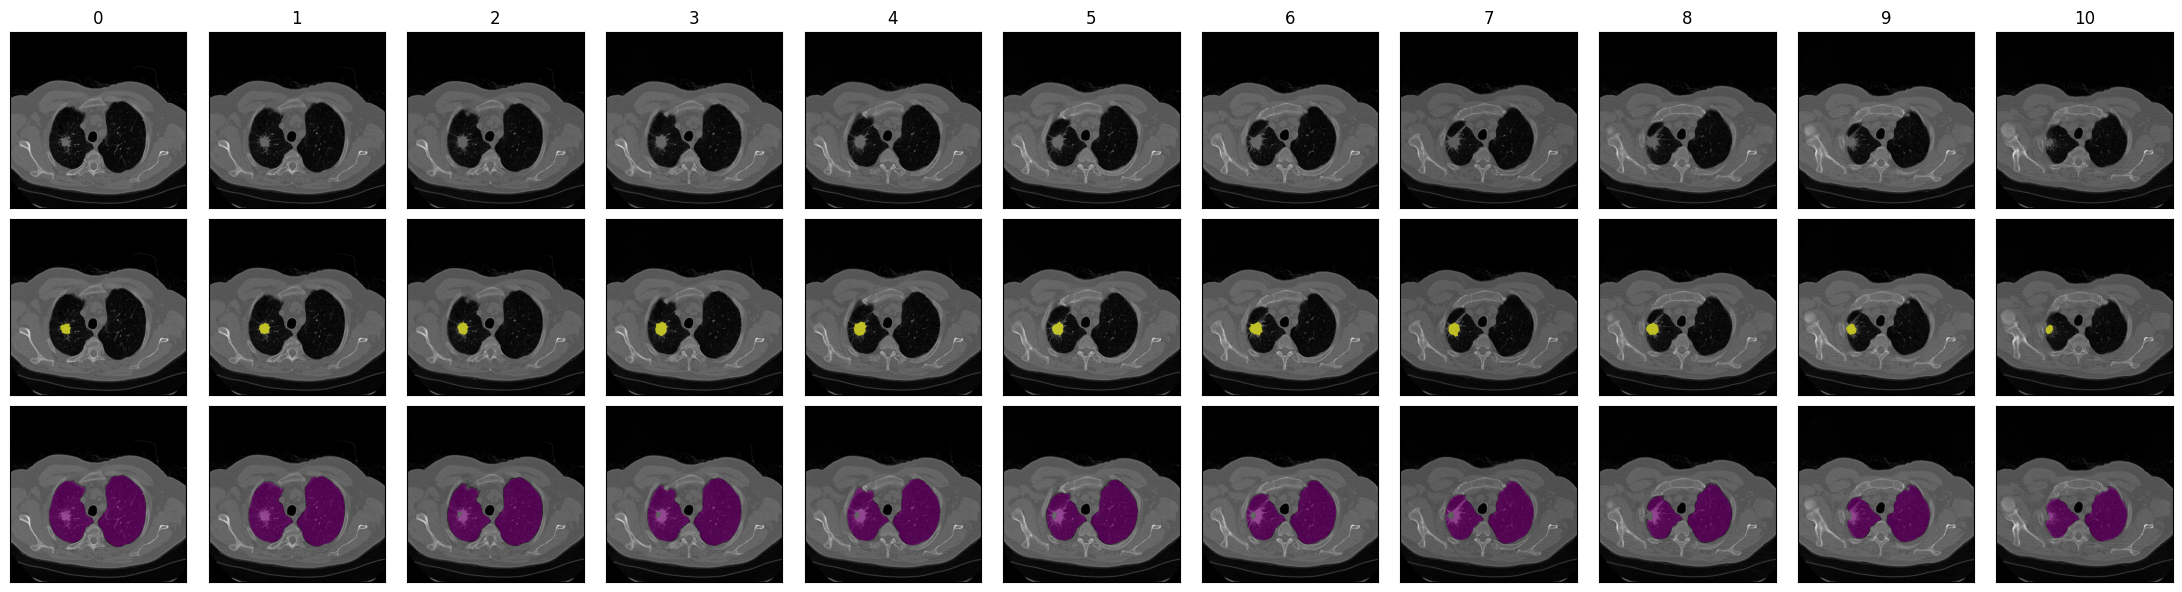

In [94]:
num_overlapping_slices = len(df_nlstseg)
print('num_overlapping_slices: ' + str(num_overlapping_slices))

num_rows = 3
num_columns = num_overlapping_slices
print('num_rows: ' + str(num_rows))
print('num_columns: ' + str(num_columns))
fig, ax = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(num_overlapping_slices*2, 6), constrained_layout=True)

temp_directory = "/content/dicom"
if not os.path.isdir(temp_directory):
  os.mkdir(temp_directory)

metrics_list = []
for n in range(0,num_overlapping_slices):

  col_index = n
  print('n: ' + str(n))

  # Get the referenced SOPInstanceUID
  SOPInstanceUID = df_nlstseg['SOPInstanceUID'].values[n]

  # Download the single SOPInstanceUID
  gcs_url = df_nlstseg['gcs_url'].values[n]
  ct_filename = os.path.join(temp_directory, 'sop.dcm')
  !gsutil cp $gcs_url $ct_filename

  # Get the CT data
  dcm = pydicom.dcmread(ct_filename)
  img = dcm.pixel_array

  # Plot the CT image
  ax[0,col_index].imshow(img, cmap='gray')
  ax[0,col_index].get_xaxis().set_visible(False)
  ax[0,col_index].get_yaxis().set_visible(False)
  ax[0,col_index].set_title(str(n))

  # Row for the CT image + nodule
  row_index = 1
  ax[row_index,col_index].imshow(img, cmap='gray')
  ax[row_index,col_index].get_xaxis().set_visible(False)
  ax[row_index,col_index].get_yaxis().set_visible(False)
  # Add the tumor segmentation for now
  # Add the segmentation to the plot
  mask_slice = mask_data[n,:,:]
  # ax[row_index,col_index].imshow(mask_slice, cmap='Reds', alpha=0.3)
  overlay = np.zeros((*mask_slice.shape, 4))
  # overlay[mask_slice > 0] = (*plt.cm.get_cmap('Blues')(1)[:3], 0.3)  # RGB + alpha
  overlay[mask_slice > 0] = (1, 1, 0, 0.6)  # RGB + alpha
  ax[row_index,col_index].imshow(overlay)

  # Row for the CT image + lung
  row_index = 2
  ax[row_index,col_index].imshow(img, cmap='gray')
  ax[row_index,col_index].get_xaxis().set_visible(False)
  ax[row_index,col_index].get_yaxis().set_visible(False)
  # Add the lung segmentation
  # (combine the lung segmentations on a slice into a single mask?)
  # Get the rows of df_ts that have the same SOPInstanceUID
  df_ts_segments = df_ts[df_ts['SOPInstanceUID']==SOPInstanceUID]
  num_segments = len(df_ts_segments)
  segment_list = df_ts_segments['mask_slice'].values
  mask_data_ts_segments = mask_data_ts[segment_list,:,:]
  mask_slice_ts = (mask_data_ts_segments > 0).any(axis=0).astype(np.uint8)
  mask_slice_ts = np.flipud(mask_slice_ts)

  # ax[row_index,col_index].imshow(mask_slice, cmap='Reds', alpha=0.3)
  overlay = np.zeros((*mask_slice_ts.shape, 4))
  # overlay[mask_slice > 0] = (*plt.cm.get_cmap('Blues')(1)[:3], 0.3)  # RGB + alpha
  overlay[mask_slice_ts > 0] = (1, 0, 1, 0.3)  # RGB + alpha - pink
  ax[row_index,col_index].imshow(overlay) # why flipup?

  ### Calculate some metrics per slice ###
  # tumor containment fraction = (tumor intersect with lung)/(tumor)
  # closer to 0 the better
  intersection = np.logical_and(mask_slice, mask_slice_ts)
  tcf = intersection.sum() / mask_slice.sum()
  metrics_list.append(tcf)

plt.tight_layout()
plt.show()


In [95]:
df_metrics = pd.DataFrame()
df_metrics['SOPInstanceUID'] = df_nlstseg['SOPInstanceUID'].values
df_metrics['mask_slice'] = np.arange(0,len(df_nlstseg))
df_metrics['metric'] = metrics_list

df_metrics

# There are no slices where the lung does not include some of the tumor :(

,SOPInstanceUID,mask_slice,metric
0,1.2.840.113654.2.55.13998794245265636889281938...,0,1.000000
1,1.2.840.113654.2.55.92014902492788269776983279...,1,0.997647
2,1.2.840.113654.2.55.84705608724374715224219052...,2,0.866292
3,1.2.840.113654.2.55.30065144618242790472755750...,3,0.864392
4,1.2.840.113654.2.55.33864278056094434912780366...,4,0.870782
5,1.2.840.113654.2.55.82622644398986097265317855...,5,0.813000
6,1.2.840.113654.2.55.24017737918811694854352532...,6,0.802130
7,1.2.840.113654.2.55.19755032706118208307243774...,7,0.758886
8,1.2.840.113654.2.55.66323297372561385302687603...,8,0.632790
9,1.2.840.113654.2.55.29148859922133669813638716...,9,0.621232
